In [1]:
import random
import argparse
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
import torch
from torch.distributions import OneHotCategorical
from data import get_data_loader
from models import *
from utils import *

%matplotlib inline

set_seed()

Random seed set as 3013


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--experiment_name", type=str,
                    default="gmmarkov-gan2", help="name of the experiment")
parser.add_argument("--dataset_prefix", type=str,
                    default="eeg_dataset/", help="path to the train and valid dataset")
parser.add_argument("--epoch", type=int, default=600,
                    help="epoch to start training from")
parser.add_argument("--gpu_idx", type=int,
                    default=1, help="GPU index")
parser.add_argument("--batch_size", type=int, default=128,
                    help="size of the batches")
parser.add_argument("--preload_gpu", type=bool,
                    default=True, help="Preload data to GPU")
parser.add_argument("--sampling_rate", type=int, default=256,
                    help="sampling rate of the signals")

args, unknown = parser.parse_known_args()
print(args)

device = torch.device('cuda:%s' %
                      args.gpu_idx if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
print(cuda, device)

dataloader = get_data_loader(args.dataset_prefix, args.batch_size, device=device,
                             shuffle=False, preload_gpu=args.preload_gpu, training=False)
dataloader_ictal = get_data_loader(args.dataset_prefix, args.batch_size, device=device,
                             shuffle=False, preload_gpu=args.preload_gpu, training=False, ictal=True)

N_GM = 10
PI = torch.tensor([1. / N_GM, ] * N_GM)
LATENT_DIM = 128
EPS_DIM = 16
V_DIM = 32
C_SIZE = 6
T = 10
ECHANNELS = 23
d = 24

prior_k = OneHotCategorical(PI)
com_mu_sig = GMM(N_GM, LATENT_DIM)
generatorG = GeneratorG(h_size=LATENT_DIM, v_size=V_DIM, c_size=C_SIZE, echannels=ECHANNELS, d=d)
generatorO = DynamicGeneratorO(v_size=V_DIM)
extractor1 = Extractor1(h_size=LATENT_DIM, T=T, c_size=C_SIZE, echannels=ECHANNELS, d=d)
extractor2 = DynamicExtractor2(v_size=V_DIM, echannels=ECHANNELS, d=d)
hyper_extractor = HyperExtractor(z_size=LATENT_DIM, n_gm=N_GM)

pretrained_path = "saved_models/%s/multi_models_%s.pth" % (args.experiment_name, args.epoch)
checkpoint = torch.load(pretrained_path)
com_mu_sig.load_state_dict(checkpoint['com_mu_state_dict'])
generatorG.load_state_dict(checkpoint['generatorG_state_dict'])
generatorO.load_state_dict(checkpoint['generatorO_state_dict'])
extractor1.load_state_dict(checkpoint['extractor1_state_dict'])
extractor2.load_state_dict(checkpoint['extractor2_state_dict'])
hyper_extractor.load_state_dict(checkpoint['hyper_extractor_state_dict'])

if cuda:
    to_device([com_mu_sig, generatorG, generatorO, extractor1, extractor2, hyper_extractor], device)

Namespace(experiment_name='gmmarkov-gan2', dataset_prefix='eeg_dataset/', epoch=600, gpu_idx=1, batch_size=128, preload_gpu=True, sampling_rate=256)
True cuda:1
eeg_dataset/patient1_interictal_test.npy (1548, 23, 2560)
eeg_dataset/patient3_interictal_test.npy (2370, 23, 2560)
eeg_dataset/patient5_interictal_test.npy (1558, 23, 2560)
eeg_dataset/patient2_interictal_test.npy (2579, 23, 2560)
eeg_dataset/patient6_interictal_test.npy (2659, 23, 2560)
eeg_dataset/patient10_interictal_test.npy (2367, 23, 2560)
train_data (13081, 23, 2560)
eeg_dataset/patient1_ictal.npy (72, 23, 2560)
eeg_dataset/patient3_ictal.npy (54, 23, 2560)
eeg_dataset/patient5_ictal.npy (72, 23, 2560)
eeg_dataset/patient2_ictal.npy (24, 23, 2560)
eeg_dataset/patient6_ictal.npy (51, 23, 2560)
eeg_dataset/patient10_ictal.npy (66, 23, 2560)
train_data (339, 23, 2560)


## Clustering

In [3]:
regen_samples = []
valid_data = []
h_q_batch = []
h_q2_batch = []
all_conds = []
k_q_batch = []
mu_q_batch = []

for i, batch in enumerate(dataloader): 
    X_q, conds = batch[0], batch[1]
    all_conds.append(conds.squeeze().detach().cpu().numpy())
    x_T_q = torch.split(X_q, split_size_or_sections=args.sampling_rate, dim=-1)
    h_q, mu_q, sig_q = extractor1(x_T_q, device, conds)
    mu_q_batch.append(mu_q.squeeze().detach().cpu().numpy())
    
    k_q = hyper_extractor(h_q)
    k_q_batch.append(k_q.squeeze().detach().cpu().numpy())
    hyper_noise = torch.randn(k_q.shape[0], LATENT_DIM).to(device)
    h_q2 = hyper_generator(com_mu_sig, k_q, hyper_noise)

    h_q_batch.append(h_q.squeeze().detach().cpu().numpy())
    h_q2_batch.append(h_q2.squeeze().detach().cpu().numpy())
    
    v_T_q = []
    for idx in range(T):
        v_T_q.append(extractor2(x_T_q[idx]))
    
    x_T_p = []
    for idx in range(T):
        xt_p = generatorG(h_q, v_T_q[idx], conds)
        x_T_p.append(xt_p)
    
    regen_samples.append(torch.cat(x_T_p, dim=-1).squeeze().detach().cpu())
    valid_data.append(X_q.squeeze().detach().cpu())

In [4]:
regen_samples, valid_data = torch.cat(regen_samples, dim=0), torch.cat(valid_data, dim=0)

In [5]:
h_q, mu_q, h_q2 = np.concatenate(h_q_batch, axis=0), np.concatenate(mu_q_batch, axis=0), np.concatenate(h_q2_batch, axis=0)

In [6]:
embedded_hq = TSNE(n_components=2, perplexity=30, n_jobs=-1).fit_transform(mu_q)

In [7]:
all_conds = np.concatenate(all_conds, axis=0)
print(all_conds.shape)
lbs = np.argmax(all_conds, axis=-1)
np.sum(lbs==0), np.sum(lbs==1), np.sum(lbs==2), np.sum(lbs==3), np.sum(lbs==4), np.sum(lbs==5)

(13056, 6)


(1548, 2370, 1558, 2579, 2659, 2342)

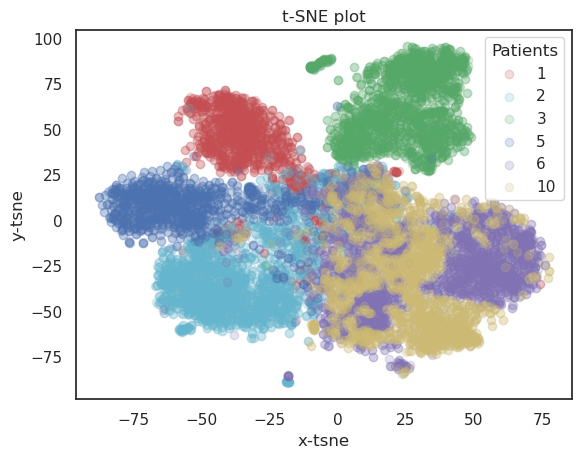

In [8]:
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'

i = 0
plt.scatter(x=embedded_hq[lbs==i,0], y=embedded_hq[lbs==i,1], c=colors[i], alpha=0.2, label=str(1))

i = 3
plt.scatter(x=embedded_hq[lbs==i,0], y=embedded_hq[lbs==i,1], c=colors[i], alpha=0.2, label=str(2))

i = 1
plt.scatter(x=embedded_hq[lbs==i,0], y=embedded_hq[lbs==i,1], c=colors[i], alpha=0.2, label=str(3))

i = 2
plt.scatter(x=embedded_hq[lbs==i,0], y=embedded_hq[lbs==i,1], c=colors[i], alpha=0.2, label=str(5))

i = 4
plt.scatter(x=embedded_hq[lbs==i,0], y=embedded_hq[lbs==i,1], c=colors[i], alpha=0.2, label=str(6))

i = 5
plt.scatter(x=embedded_hq[lbs==i,0], y=embedded_hq[lbs==i,1], c=colors[i], alpha=0.2, label=str(10))

plt.xlabel('x-tsne')
plt.ylabel('y-tsne')
plt.title('t-SNE plot')
plt.legend(title="Patients")

## Detecting epilepsy seizure

In [9]:
regen_ictal_samples = []
ictal_data = []

for i, batch in enumerate(dataloader_ictal): 
    X_q, conds = batch[0], batch[1]
    x_T_q = torch.split(X_q, split_size_or_sections=args.sampling_rate, dim=-1)
    h_q, mu_q, sig_q = extractor1(x_T_q, device,  conds)

    v_T_q = []
    for idx in range(T):
        v_T_q.append(extractor2(x_T_q[idx]))
    
    x_T_p = []
    for idx in range(T):
        xt_p = generatorG(h_q, v_T_q[idx], conds)
        x_T_p.append(xt_p)
    
    regen_ictal_samples.append(torch.cat(x_T_p, dim=-1).squeeze().detach().cpu())
    ictal_data.append(X_q.squeeze().detach().cpu())

In [10]:
regen_ictal_samples, ictal_data = torch.cat(regen_ictal_samples, dim=0), torch.cat(ictal_data, dim=0)

In [11]:
mse = torch.nn.L1Loss(reduction='none')

In [12]:
rec_inter = mse(valid_data, regen_samples)
rec_inter = torch.mean(rec_inter, dim=[-1,-2])
rec_ictal = mse(ictal_data, regen_ictal_samples)
rec_ictal = torch.mean(rec_ictal, dim=[-1,-2])

In [13]:
y_true = [0] * len(rec_inter) + [1] * len(rec_ictal)
scores = torch.cat([rec_inter, rec_ictal]).detach().numpy()
fpr, tpr, thresholds = roc_curve(y_true, scores, pos_label = 1)

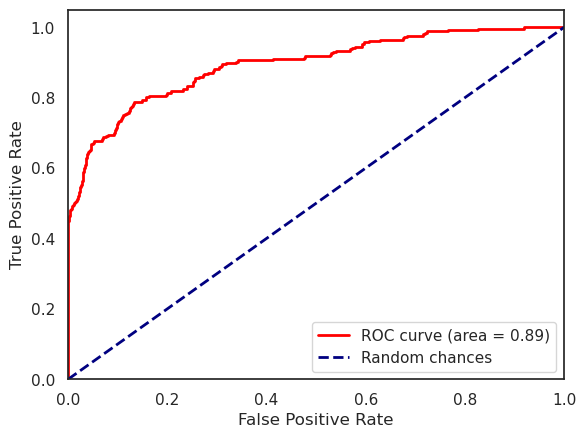

In [14]:
plt.plot(fpr, tpr, color='red',
         lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random chances')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

## Plotting some channels

In [15]:
gen_samples = []

for i, batch in enumerate(dataloader): 
    conds = batch[1]
    sz = conds.shape[0]
    k_p = prior_k.sample((sz,)).to(device)
    hyper_noise = torch.randn(sz, LATENT_DIM, device=device)
    h_p = hyper_generator(com_mu_sig, k_p, hyper_noise)
    vt_p = torch.randn(sz, V_DIM, device=device)
    
    x_T_p = []
    for idx in range(T):
        xt_p = generatorG(h_p, vt_p, conds)
        x_T_p.append(xt_p)
        if idx < T - 1:
            epst_p = torch.randn(sz, EPS_DIM).to(device)
            vt_p = generatorO(vt_p, epst_p)
            
    gen_samples.append(torch.cat(x_T_p, dim=-1).squeeze().detach().cpu().numpy())

In [16]:
gen_samples = np.concatenate(gen_samples, axis=0)

In [17]:
valid_data = valid_data.numpy()

### Real

/home/khuong/Projects/eeg-graphical-gan/utils.py:88: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0, hspace=-0.1)


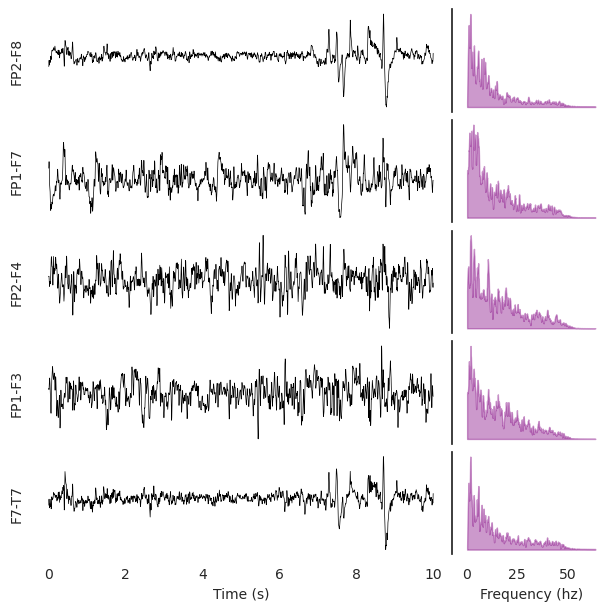

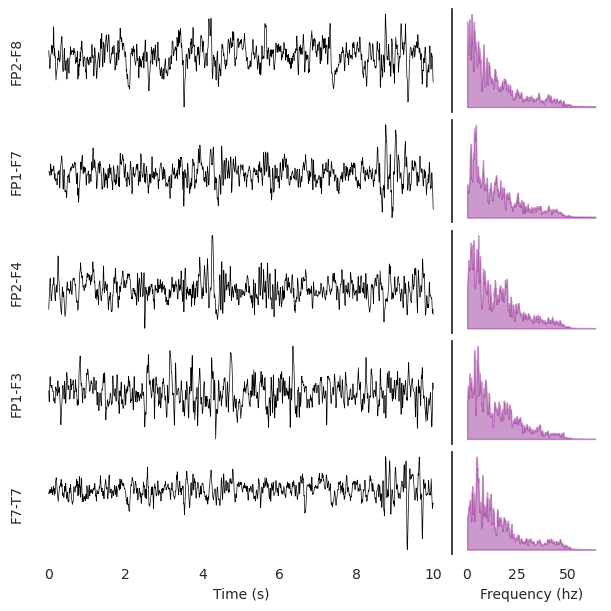

In [18]:
plot_23channels_oop(valid_data[463])
plot_23channels_oop(valid_data[123])

### Synthetic 

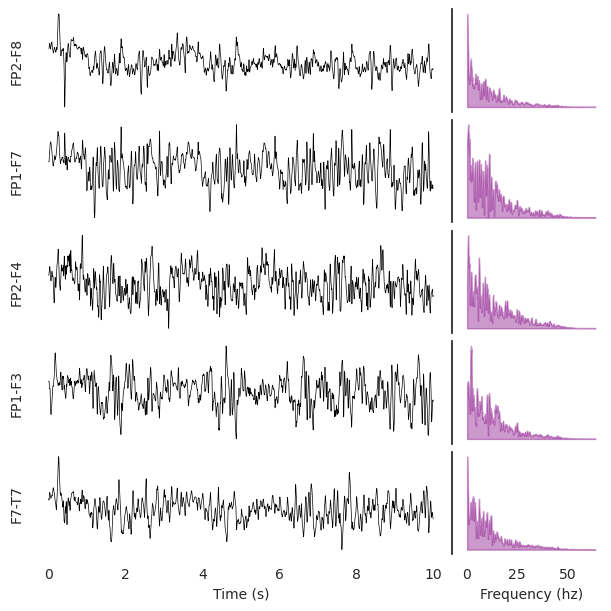

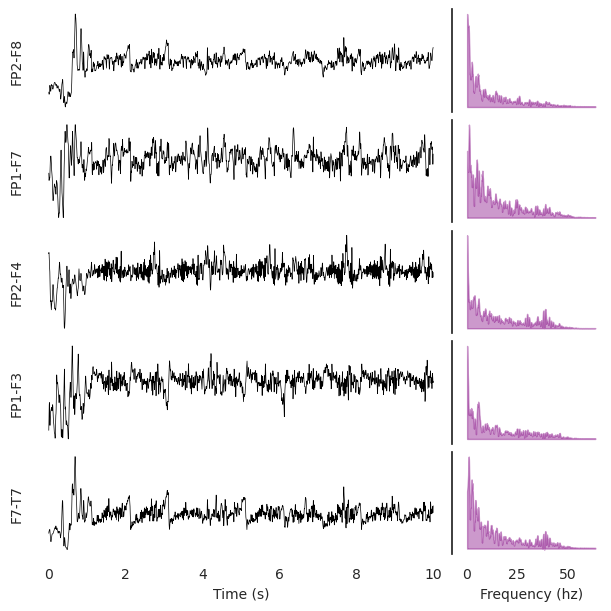

In [21]:
plot_23channels_oop(gen_samples[780])
plot_23channels_oop(gen_samples[6000])